In [167]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import lenstronomy
import numpy as np
import os
import pickle
import copy
import time
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import h5py
from pprint import pprint
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import LogFormatter 
import matplotlib.colors as colors

import lenstronomy.Util.util as util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Analysis.lens_profile import LensProfileAnalysis
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.ImSim.differential_extinction import DifferentialExtinction
from lenstronomy.Plots import chain_plot
from lenstronomy.Util import mask_util
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util.util import array2image
from lenstronomy.Util import param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
import pickle
import joblib

cwd = os.getcwd()
base_path, _ = os.path.split(cwd)
print(base_path)


/Users/pierreboccard/Doc/EPFL/PDM/Files


In [168]:
cosmow = False

[ 1.95506024 -1.81992773 -1.93423272  0.17445549] [-1.49731766  0.4310645  -1.03356661  1.43369151]


/var/folders/fs/pvtv8t8x15gbvc9qcpcjbtjm0000gn/T/ipykernel_11732/3379968464.py:81: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_sim), origin='lower')


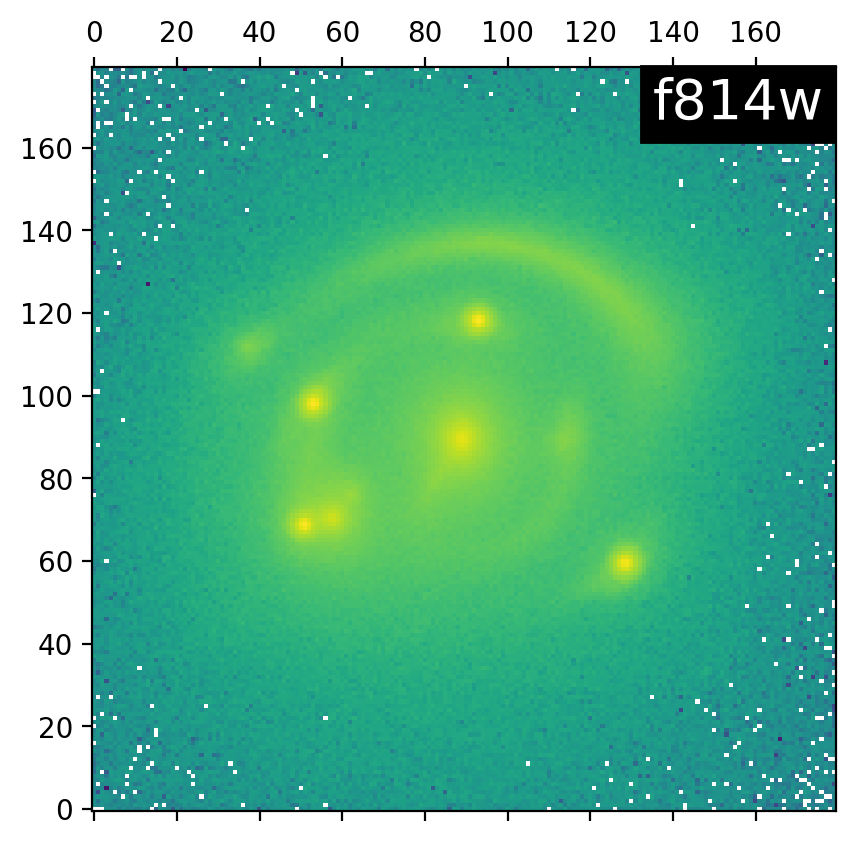

In [169]:
from astropy.cosmology import FlatLambdaCDM, wCDM
import astropy.units as u

if cosmow == True : 
  cosmo = wCDM(H0 = 5 * u.km / u.s / u.Mpc, Om0 = 0.01, Ode0 = 0.2, w0=-0.3, Tcmb0=0.0, Neff=3.04, m_nu=None, Ob0=None)
else : 
  cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3, Ob0=0.05) # define cosmology 


background_rms = .005  # background noise per pixel
exp_time = 70  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 180  # cutout pixel size
deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.15  # full width half max of PSF
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
ra_at_xy_0 = kwargs_data['ra_at_xy_0']
dec_at_xy_0 = kwargs_data['dec_at_xy_0']

psf_file = os.path.join(base_path, 'data', 'psf_{}.hdf5'.format('f814w'))
f = h5py.File(psf_file, 'r')
kernel_point_source = f['kernel_point_source'][()]
f.close()
kwargs_psf = {'psf_type': 'PIXEL', 'fwhm': fwhm, 'kernel_point_source' : kernel_point_source,'pixel_size': deltaPix}
psf_class = PSF(**kwargs_psf)

lens_model_list = ['EPL', 'SHEAR_GAMMA_PSI', 'SIS', 'SIS', 'NFW_MC', 'NFW_MC', 'NFW_MC', 'SIS']
kwargs_lens = {'theta_E': 1.630733482158986, 'gamma': 1.7356277714330814, 'e1': -0.008564148200000756, 'e2': 0.21337107343436382, 'center_x': 0.044568442028076576, 'center_y': 0.05368204192058385}, {'gamma_ext': 0.06886039874490402, 'psi_ext': 0.44433171264726073, 'ra_0': 0, 'dec_0': 0}, {'theta_E': 0.23406223967290868, 'center_x': -1.5953498841234257, 'center_y': -0.957809036129075}, {'theta_E': 0.34963329845029806, 'center_x': 1.0839901104658902, 'center_y': -6.516121582054507}, {'logM': 12.293473116012454, 'concentration': 5.2938866677526955, 'center_x': -0.39902264938181325, 'center_y': -13.577953376770608}, {'logM': 11.477597163775352, 'concentration': 5.70382830617051, 'center_x': 5.342383555962899, 'center_y': -0.7750999830473467}, {'logM': 11.976107801672256, 'concentration': 6.268418658636125, 'center_x': 10.900788854734145, 'center_y': 5.532826990356399}, {'theta_E': 0.015584169135015678, 'center_x': -0.23937757570238552, 'center_y': -0.42697007646715346}

lens_model_class = LensModel(lens_model_list=lens_model_list, z_lens=0.597, z_source=2.375, lens_redshift_list=[0.597, 0.597, 0.597, 0.769, 0.597, 0.597, 0.597, 2.228], cosmo = cosmo, multi_plane = True, observed_convention_index = [3], distance_ratio_sampling=False)

lens_light_model_list = ['SERSIC_ELLIPSE', 'SERSIC']
kwargs_sersic1 = {'amp': 300, 'R_sersic': 1.3107179349829883, 'n_sersic': 4.990590806229146, 'e1': -0.10074301681449246, 'e2': -0.007225875846854489, 'center_x': -0.0269328863916088, 'center_y': -0.0009476874990389448}
kwargs_sersic5 = {'amp': 300, 'R_sersic': 0.7153455129669464, 'n_sersic': 5.47386849989048, 'center_x': -1.5953498841234257, 'center_y': -0.957809036129075}
kwargs_lens_light = [kwargs_sersic1, kwargs_sersic5]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

source_model_list = ['SERSIC_ELLIPSE', 'SHAPELETS', 'SERSIC_ELLIPSE', 'SHAPELETS', 'SERSIC_ELLIPSE']
kwargs_sersic_ellipse1 = {'amp': 300, 'R_sersic': 0.1384339249900818, 'n_sersic': 4.578407529095215, 'e1': 0.1450869654923371, 'e2': -0.0948050061711261, 'center_x': 0.38271559291321455, 'center_y': -0.8854724336923326}
kwargs_sersic_ellipse2 = {'amp': np.array([-145.4652772,  -95.457246 , -342.0098006,  362.9274458,
         31.4860728,  807.0570954, -135.775063 , -385.1590964,
        438.5707994, -495.6887174,   88.2902438,  192.8002232,
          8.8235598, -242.6025906,  109.764719 , -116.9584056,
         69.9585814, -231.7726532,  450.530179 ,   22.379439 ,
        420.054362 ]), 'n_max': 5, 'beta': 0.06391939604087729, 'center_x': 0.38271559291321455, 'center_y': -0.8854724336923326}
kwargs_sersic_ellipse3 = {'amp': 300, 'R_sersic': 0.10926862916942076, 'n_sersic': 1.9511477861910127, 'e1': 0.21767526735440174, 'e2': -0.17377131188610687, 'center_x': -0.2486096521902502, 'center_y': -0.4300089078005465}
kwargs_sersic_ellipse4 = {'amp': np.array([ 464.8516802,  790.1919092, -352.6479768,  364.5957062,
       -278.2390454,  142.7464818,   34.2912008, -234.4921504,
         -6.3224778,  -94.9034732]), 'n_max': 3, 'beta': 0.06445713707040127, 'center_x': -0.2486096521902502, 'center_y': -0.4300089078005465}
kwargs_sersic_ellipse5 = {'amp': 300, 'R_sersic': 0.27501389572859, 'n_sersic': 1.6905976552642201, 'e1': 0.2304847171017094, 'e2': 0.30374241488788356, 'center_x': 0.4580329178635046, 'center_y': -0.19633835837213806}
kwargs_source = [kwargs_sersic_ellipse1, kwargs_sersic_ellipse2,kwargs_sersic_ellipse3, kwargs_sersic_ellipse4, kwargs_sersic_ellipse5]
source_model_class = LightModel(light_model_list=source_model_list, source_redshift_list=[2.375, 2.375, 2.228, 2.228, 2.375])


ra_source, dec_source = 0.38271559, -0.88547243
lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, kwargs_lens, numImages=4, min_distance=deltaPix, search_window=numPix * deltaPix)
print(x_image,y_image)

kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image, 'point_amp': 1000}]  #quasar point source position in the source plane and intrinsic brightness
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False], lensModel=lens_model_class)
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,lens_light_model_class,point_source_class,kwargs_numerics=kwargs_numerics)
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
image_sim = image_sim + bkg + poisson

kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)


if cosmow == True : 
  np.savetxt('image_sim814.txt', image_sim)
else : 
  np.savetxt('image_sim814bis.txt', image_sim)


plt.matshow(np.log10(image_sim), origin='lower')
plt.text(135, 167, 'f814w', fontsize = 20, color = 'white',
        bbox = dict(facecolor = 'black', alpha = 1))
plt.savefig('/Users/pierreboccard/Doc/EPFL/PDM/Rapport/model.png', dpi = 250)
plt.show()


[ 1.95506024 -1.81992773 -1.93423272  0.17445549] [-1.49731766  0.4310645  -1.03356661  1.43369151]


/var/folders/fs/pvtv8t8x15gbvc9qcpcjbtjm0000gn/T/ipykernel_11732/2043415734.py:79: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_sim2), origin='lower')


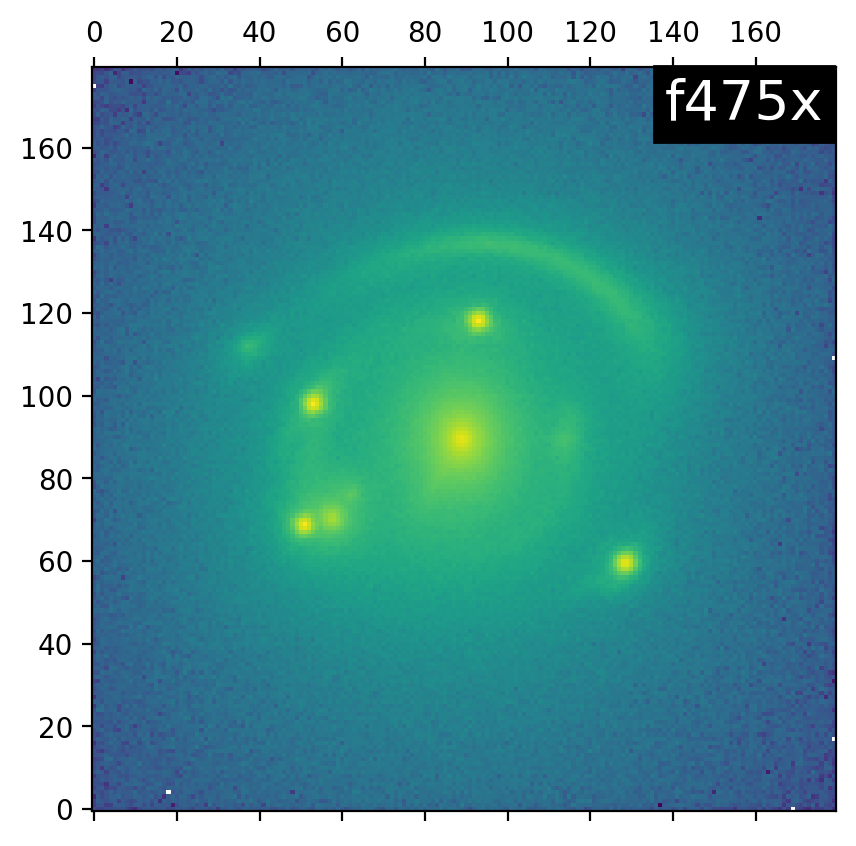

In [170]:
from astropy.cosmology import FlatLambdaCDM, wCDM
import astropy.units as u

if cosmow == True : 
  cosmo = wCDM(H0 = 5 * u.km / u.s / u.Mpc, Om0 = 0.01, Ode0 = 0.2, w0=-0.3, Tcmb0=0.0, Neff=3.04, m_nu=None, Ob0=None)
else : 
  cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3, Ob0=0.05) # define cosmology 

background_rms = .005  # background noise per pixel
exp_time = 70  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 180  # cutout pixel size
deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.15  # full width half max of PSF
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
ra_at_xy_0 = kwargs_data['ra_at_xy_0']
dec_at_xy_0 = kwargs_data['dec_at_xy_0']
psf_file = os.path.join(base_path, 'data', 'psf_{}.hdf5'.format('f475x'))
f = h5py.File(psf_file, 'r')
kernel_point_source = f['kernel_point_source'][()]
f.close()
kwargs_psf = {'psf_type': 'PIXEL', 'fwhm': fwhm, 'kernel_point_source' : kernel_point_source,'pixel_size': deltaPix}
psf_class = PSF(**kwargs_psf)

lens_model_list = ['EPL', 'SHEAR_GAMMA_PSI', 'SIS', 'SIS', 'NFW_MC', 'NFW_MC', 'NFW_MC', 'SIS']
kwargs_lens = {'theta_E': 1.630733482158986, 'gamma': 1.7356277714330814, 'e1': -0.008564148200000756, 'e2': 0.21337107343436382, 'center_x': 0.044568442028076576, 'center_y': 0.05368204192058385}, {'gamma_ext': 0.06886039874490402, 'psi_ext': 0.44433171264726073, 'ra_0': 0, 'dec_0': 0}, {'theta_E': 0.23406223967290868, 'center_x': -1.5953498841234257, 'center_y': -0.957809036129075}, {'theta_E': 0.34963329845029806, 'center_x': 1.0839901104658902, 'center_y': -6.516121582054507}, {'logM': 12.293473116012454, 'concentration': 5.2938866677526955, 'center_x': -0.39902264938181325, 'center_y': -13.577953376770608}, {'logM': 11.477597163775352, 'concentration': 5.70382830617051, 'center_x': 5.342383555962899, 'center_y': -0.7750999830473467}, {'logM': 11.976107801672256, 'concentration': 6.268418658636125, 'center_x': 10.900788854734145, 'center_y': 5.532826990356399}, {'theta_E': 0.015584169135015678, 'center_x': -0.23937757570238552, 'center_y': -0.42697007646715346}

lens_model_class = LensModel(lens_model_list=lens_model_list, z_lens=0.597, z_source=2.375, lens_redshift_list=[0.597, 0.597, 0.597, 0.769, 0.597, 0.597, 0.597, 2.228], cosmo = cosmo, multi_plane = True, observed_convention_index = [3], distance_ratio_sampling=False)

lens_light_model_list = ['SERSIC_ELLIPSE', 'SERSIC']
kwargs_sersic2 = {'amp': 300, 'R_sersic': 2.6539953448774574, 'n_sersic': 4.382369291437385, 'e1': -0.10074301681449246, 'e2': -0.007225875846854489, 'center_x': -0.0269328863916088, 'center_y': -0.0009476874990389448}
kwargs_sersic5 = {'amp': 300, 'R_sersic': 0.7153455129669464, 'n_sersic': 5.47386849989048, 'center_x': -1.5953498841234257, 'center_y': -0.957809036129075}
kwargs_lens_light = [kwargs_sersic2, kwargs_sersic5]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

source_model_list = ['SERSIC_ELLIPSE', 'SHAPELETS', 'SERSIC_ELLIPSE', 'SHAPELETS', 'SERSIC_ELLIPSE']
kwargs_sersic_ellipse1 = {'amp': 300, 'R_sersic': 0.1384339249900818, 'n_sersic': 4.578407529095215, 'e1': 0.1450869654923371, 'e2': -0.0948050061711261, 'center_x': 0.38271559291321455, 'center_y': -0.8854724336923326}
kwargs_sersic_ellipse2 = {'amp': np.array([-145.4652772,  -95.457246 , -342.0098006,  362.9274458,
         31.4860728,  807.0570954, -135.775063 , -385.1590964,
        438.5707994, -495.6887174,   88.2902438,  192.8002232,
          8.8235598, -242.6025906,  109.764719 , -116.9584056,
         69.9585814, -231.7726532,  450.530179 ,   22.379439 ,
        420.054362 ]), 'n_max': 5, 'beta': 0.06391939604087729, 'center_x': 0.38271559291321455, 'center_y': -0.8854724336923326}
kwargs_sersic_ellipse3 = {'amp': 300, 'R_sersic': 0.10926862916942076, 'n_sersic': 1.9511477861910127, 'e1': 0.21767526735440174, 'e2': -0.17377131188610687, 'center_x': -0.2486096521902502, 'center_y': -0.4300089078005465}
kwargs_sersic_ellipse4 = {'amp': np.array([ 464.8516802,  790.1919092, -352.6479768,  364.5957062,
       -278.2390454,  142.7464818,   34.2912008, -234.4921504,
         -6.3224778,  -94.9034732]), 'n_max': 3, 'beta': 0.06445713707040127, 'center_x': -0.2486096521902502, 'center_y': -0.4300089078005465}
kwargs_sersic_ellipse5 = {'amp': 300, 'R_sersic': 0.27501389572859, 'n_sersic': 1.6905976552642201, 'e1': 0.2304847171017094, 'e2': 0.30374241488788356, 'center_x': 0.4580329178635046, 'center_y': -0.19633835837213806}
kwargs_source = [kwargs_sersic_ellipse1, kwargs_sersic_ellipse2,kwargs_sersic_ellipse3, kwargs_sersic_ellipse4, kwargs_sersic_ellipse5]
source_model_class = LightModel(light_model_list=source_model_list, source_redshift_list=[2.375, 2.375, 2.228, 2.228, 2.375])

ra_source, dec_source = 0.38271559, -0.88547243

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, kwargs_lens, numImages=4, min_distance=deltaPix, search_window=numPix * deltaPix)
print(x_image,y_image)

kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image, 'point_amp': 1000}]  # quasar point source position in the source plane and intrinsic brightness
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False], lensModel=lens_model_class)
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

kwargs_special = {'scale_factor': [], 'tau0_list': [1], 'a_1': a_1, 'a_2': a_2, 'a_3': a_3, 'b_2': b_2}

imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,lens_light_model_class, point_source_class, kwargs_numerics=kwargs_numerics)
image_sim2 = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
poisson = image_util.add_poisson(image_sim2, exp_time=exp_time)
bkg = image_util.add_background(image_sim2, sigma_bkd=background_rms)
image_sim2 = image_sim2 + bkg + poisson

kwargs_data['image_data'] = image_sim2
data_class.update_data(image_sim2)

if cosmow == True : 
  np.savetxt('image_sim475.txt', image_sim2)
else : 
  np.savetxt('image_sim475bis.txt', image_sim2)

plt.matshow(np.log10(image_sim2), origin='lower')
plt.text(138, 167, 'f475x', fontsize = 20, color = 'white',
         bbox = dict(facecolor = 'black', alpha = 1))
plt.show()


[ 1.95506024 -1.81992773 -1.93423272  0.17445549] [-1.49731766  0.4310645  -1.03356661  1.43369151]


/var/folders/fs/pvtv8t8x15gbvc9qcpcjbtjm0000gn/T/ipykernel_11732/3703863848.py:93: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_sim3), origin='lower')


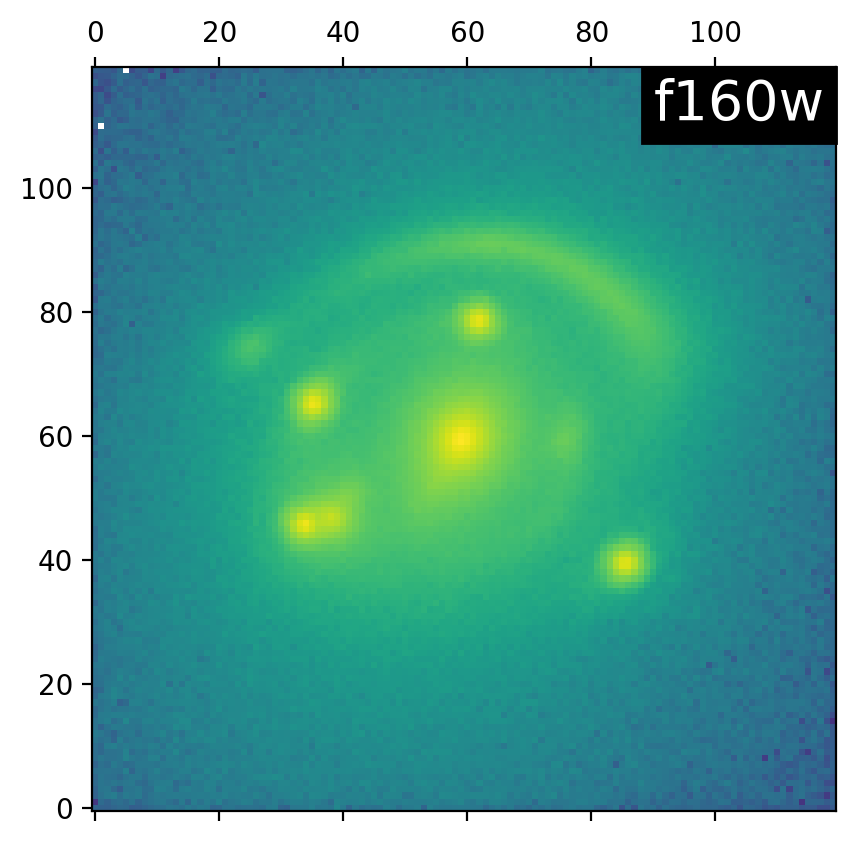

In [171]:
from astropy.cosmology import FlatLambdaCDM, wCDM
import astropy.units as u

if cosmow == True : 
  cosmo = wCDM(H0 = 5 * u.km / u.s / u.Mpc, Om0 = 0.01, Ode0 = 0.2, w0=-0.3, Tcmb0=0.0, Neff=3.04, m_nu=None, Ob0=None)
else : 
  cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3, Ob0=0.05) # define cosmology 

# background_rms = .005  # background noise per pixel
# exp_time = 70  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
# numPix = 180  # cutout pixel size
# deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
# fwhm = 0.15  # full width half max of PSF

background_rms = .01 # background noise per pixel
exp_time = 70  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 120  # cutout pixel size
deltaPix = 0.075  # pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.15  # full width half max of PSF

kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
transform_pix2angle = kwargs_data['transform_pix2angle']
ra_at_xy_0 = kwargs_data['ra_at_xy_0']
dec_at_xy_0 = kwargs_data['dec_at_xy_0']
psf_file = os.path.join(base_path, 'data', 'psf_{}.hdf5'.format('f160w'))
f = h5py.File(psf_file, 'r')
kernel_point_source = f['kernel_point_source'][()]
f.close()
kwargs_psf = {'psf_type': 'PIXEL', 'fwhm': fwhm, 'kernel_point_source' : kernel_point_source,'pixel_size': deltaPix}
psf_class = PSF(**kwargs_psf)

lens_model_list = ['EPL', 'SHEAR_GAMMA_PSI', 'SIS', 'SIS', 'NFW_MC', 'NFW_MC', 'NFW_MC', 'SIS']
kwargs_lens = {'theta_E': 1.630733482158986, 'gamma': 1.7356277714330814, 'e1': -0.008564148200000756, 'e2': 0.21337107343436382, 'center_x': 0.044568442028076576, 'center_y': 0.05368204192058385}, {'gamma_ext': 0.06886039874490402, 'psi_ext': 0.44433171264726073, 'ra_0': 0, 'dec_0': 0}, {'theta_E': 0.23406223967290868, 'center_x': -1.5953498841234257, 'center_y': -0.957809036129075}, {'theta_E': 0.34963329845029806, 'center_x': 1.0839901104658902, 'center_y': -6.516121582054507}, {'logM': 12.293473116012454, 'concentration': 5.2938866677526955, 'center_x': -0.39902264938181325, 'center_y': -13.577953376770608}, {'logM': 11.477597163775352, 'concentration': 5.70382830617051, 'center_x': 5.342383555962899, 'center_y': -0.7750999830473467}, {'logM': 11.976107801672256, 'concentration': 6.268418658636125, 'center_x': 10.900788854734145, 'center_y': 5.532826990356399}, {'theta_E': 0.015584169135015678, 'center_x': -0.23937757570238552, 'center_y': -0.42697007646715346}
lens_model_class = LensModel(lens_model_list=lens_model_list, z_lens=0.597, z_source=2.375, lens_redshift_list=[0.597, 0.597, 0.597, 0.769, 0.597, 0.597, 0.597, 2.228], cosmo = cosmo, multi_plane = True, observed_convention_index = [3], distance_ratio_sampling=False)

lens_light_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC']
kwargs_sersic1 = {'amp': 300, 'R_sersic': 0.10000391466716309, 'n_sersic': 1.061939424085716, 'e1': -0.1654259380573182, 'e2': -0.0784929092899602, 'center_x': -0.0269328863916088, 'center_y': -0.0009476874990389448}
kwargs_sersic2 = {'amp': 300, 'R_sersic': 1.96627037681673, 'n_sersic': 5.22087304581133, 'e1': -0.0747537167017987, 'e2': 0.09453396740332322, 'center_x': -0.0269328863916088, 'center_y': -0.0009476874990389448}
kwargs_sersic5 = {'amp': 300, 'R_sersic': 0.7153455129669464, 'n_sersic': 5.47386849989048, 'center_x': -1.5953498841234257, 'center_y': -0.957809036129075}
kwargs_lens_light = [kwargs_sersic1, kwargs_sersic2, kwargs_sersic5]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)


source_model_list = ['SERSIC_ELLIPSE', 'SHAPELETS', 'SERSIC_ELLIPSE', 'SHAPELETS', 'SERSIC_ELLIPSE']
kwargs_sersic_ellipse1 = {'amp': 300, 'R_sersic': 0.1384339249900818, 'n_sersic': 4.578407529095215, 'e1': 0.1450869654923371, 'e2': -0.0948050061711261, 'center_x': 0.38271559291321455, 'center_y': -0.8854724336923326}
kwargs_sersic_ellipse2 = {'amp': 0.5*np.array([-168.84282318,  -10.78086995,  -11.6831123 ,   57.22708202,
         31.6744171 ,  123.69866753,    5.60308519,   14.94642406,
         -9.96951882,   43.49006012,  -55.03459537,  -18.19911784,
        -49.35243691,  -54.98649323,  -51.68494809,   -0.70939694,
         -2.25044995,  -30.71871349,    9.5072645 ,  -10.13080918,
        -25.31573946,   17.96336178,   14.28622533,    5.54252307,
         15.15183612,   41.26755763,   18.38773642,   23.25281581,
         -5.11325765,    5.74664848,   11.87829126,    2.74750154,
          1.84234304,    4.71111214,   -1.72486723,   -1.76581814,
        -16.96781979,   -3.05465211,    4.33773338,   -8.93583135,
         -3.04787762,  -14.78100285,   -9.35482107,    1.63408225,
        -23.91128135]), 'n_max': 8, 'beta': 0.11019702776464912, 'center_x': 0.38271559291321455, 'center_y': -0.8854724336923326}
kwargs_sersic_ellipse3 = {'amp': 300, 'R_sersic': 0.10926862916942076, 'n_sersic': 1.9511477861910127, 'e1': 0.21767526735440174, 'e2': -0.17377131188610687, 'center_x': -0.2486096521902502, 'center_y': -0.4300089078005465}
kwargs_sersic_ellipse4 = {'amp': np.array([ 464.8516802,  790.1919092, -352.6479768,  364.5957062,
       -278.2390454,  142.7464818,   34.2912008, -234.4921504,
         -6.3224778,  -94.9034732]), 'n_max': 3, 'beta': 0.06445713707040127, 'center_x': -0.2486096521902502, 'center_y': -0.4300089078005465}
kwargs_sersic_ellipse5 = {'amp': 300, 'R_sersic': 0.27501389572859, 'n_sersic': 1.6905976552642201, 'e1': 0.2304847171017094, 'e2': 0.30374241488788356, 'center_x': 0.4580329178635046, 'center_y': -0.19633835837213806}
kwargs_source = [kwargs_sersic_ellipse1, kwargs_sersic_ellipse2,kwargs_sersic_ellipse3, kwargs_sersic_ellipse4, kwargs_sersic_ellipse5]
source_model_class = LightModel(light_model_list=source_model_list, source_redshift_list=[2.375, 2.375, 2.228, 2.228, 2.375])


ra_source, dec_source = 0.38271559, -0.88547243

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, kwargs_lens, numImages=4, min_distance=deltaPix, search_window=numPix * deltaPix)
print(x_image, y_image)

kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image, 'point_amp': 1000}]  # quasar point source position in the source plane and intrinsic brightness
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False], lensModel=lens_model_class)
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,lens_light_model_class, point_source_class, kwargs_numerics=kwargs_numerics)
image_sim3 = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
poisson = image_util.add_poisson(image_sim3, exp_time=exp_time)
bkg = image_util.add_background(image_sim3, sigma_bkd=background_rms)
image_sim3 = image_sim3 + bkg + poisson

kwargs_data['image_data'] = image_sim3
data_class.update_data(image_sim3)

if cosmow == True : 
  np.savetxt('image_sim160.txt', image_sim3)
else : 
  np.savetxt('image_sim160bis.txt', image_sim3)

plt.matshow(np.log10(image_sim3), origin='lower')
plt.text(90, 111, 'f160w', fontsize = 20, color = 'white',
#plt.text(138, 167, 'f160w', fontsize = 20, color = 'white',
         bbox = dict(facecolor = 'black', alpha = 1))
plt.show()


/Users/pierreboccard/lenstronomy/lenstronomy/Data/psf.py:60: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn('Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.')


-1.3070550812626918 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.3070550812626844


/Users/pierreboccard/lenstronomy/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


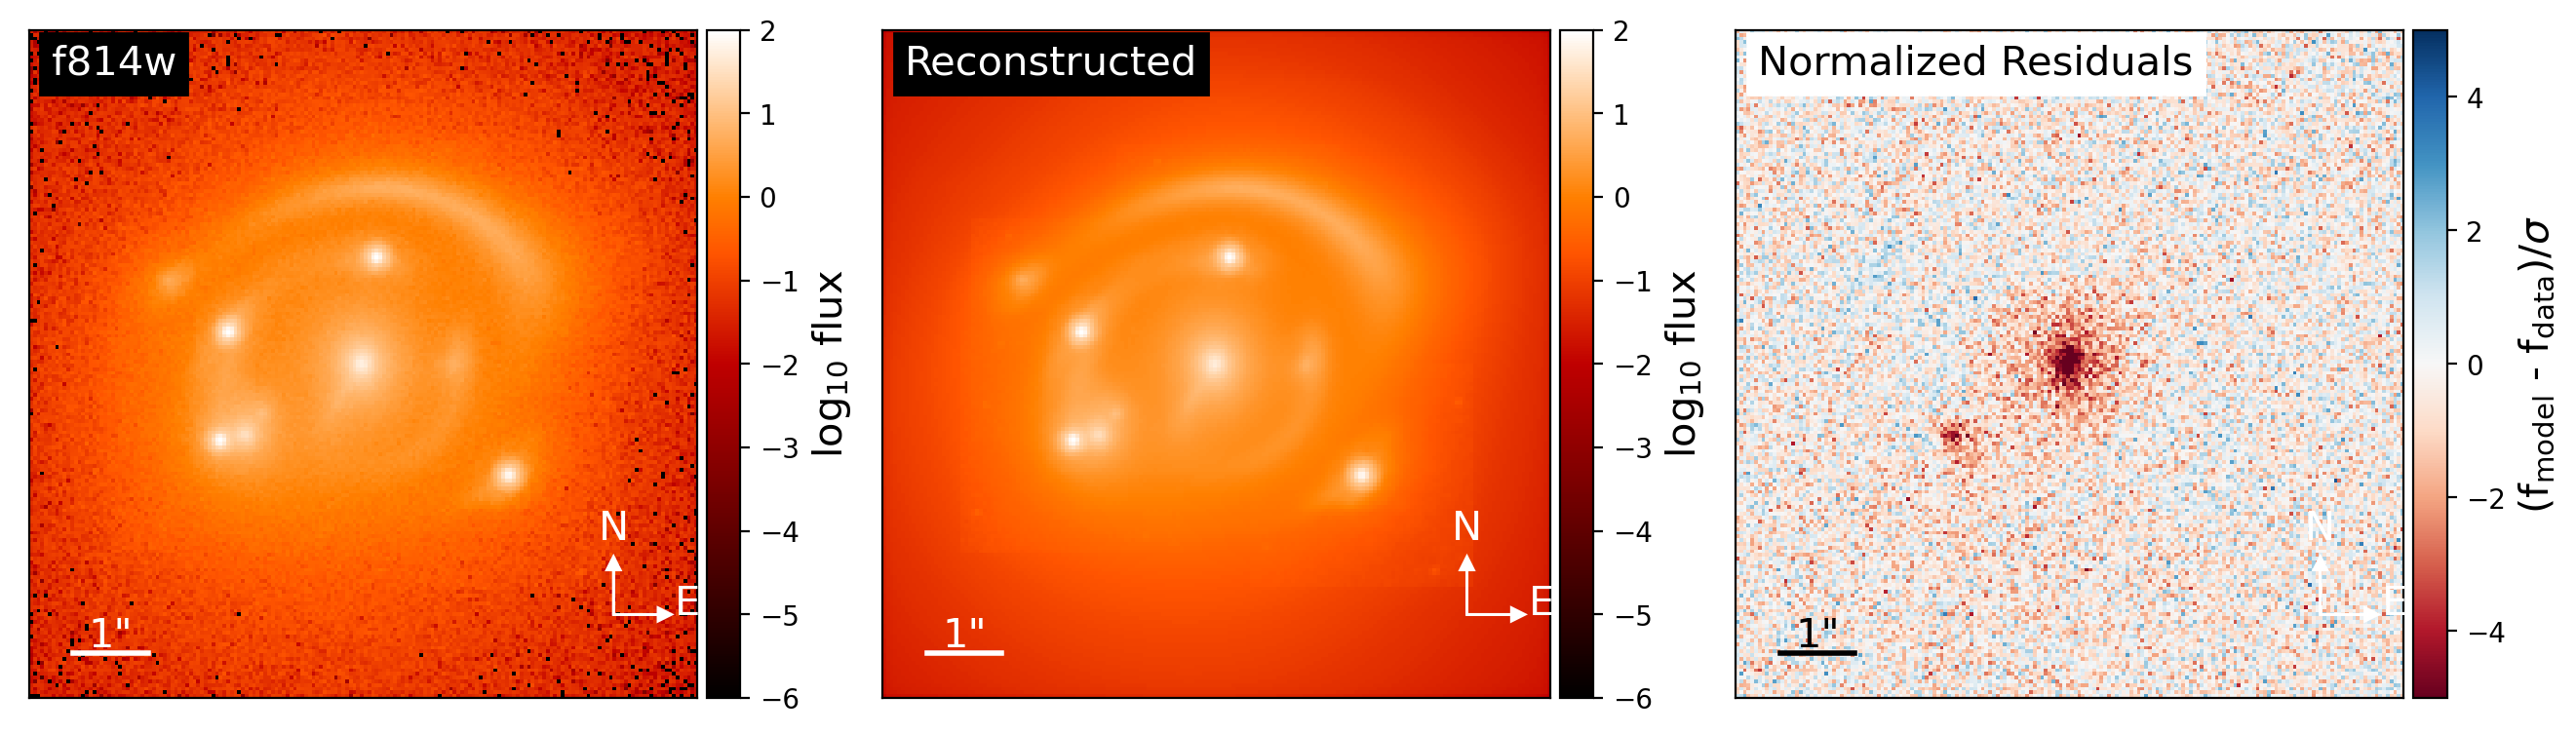

In [179]:
from astropy.cosmology import FlatLambdaCDM, wCDM
import astropy.units as u

cmap = 'cubehelix'
msh_cmap = 'RdBu'

if cosmow == True : 
    cosmo = wCDM(H0 = 5 * u.km / u.s / u.Mpc, Om0 = 0.01, Ode0 = 0.2, w0=-0.3, Tcmb0=0.0, Neff=3.04, m_nu=None, Ob0=None)
    data814 = np.loadtxt('image_sim814.txt')
    data475 = np.loadtxt('image_sim475.txt')
    data160 = np.loadtxt('image_sim160.txt')
else : 
    cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3, Ob0=0.05) # define cosmology 
    data814 = np.loadtxt('image_sim814bis.txt')
    data475 = np.loadtxt('image_sim475bis.txt')
    data160 = np.loadtxt('image_sim160bis.txt')


def import_data(filter_name):
    """
    """
    
    if filter_name == 'f160w' : 

        background_rms = .01 # background noise per pixel
        exp_time = 70  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
        numPix = 120  # cutout pixel size
        deltaPix = 0.075  # pixel size in arcsec (area per pixel = deltaPix**2)
        fwhm = 0.15  # full width half max of PSF

        kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
        data_class = ImageData(**kwargs_data)
        psf_file = os.path.join(base_path, 'data', 'psf_{}.hdf5'.format(filter_name))
        f = h5py.File(psf_file, 'r')
        kernel_point_source = f['kernel_point_source'][()]
        f.close()
        kwargs_psf = {'psf_type': 'PIXEL', 'fwhm': fwhm, 'kernel_point_source' : kernel_point_source,'pixel_size': deltaPix}
        psf_class = PSF(**kwargs_psf)
        kwargs_data['image_data'] =  data160
        ra_at_xy_0 = kwargs_data['ra_at_xy_0']
        dec_at_xy_0 = kwargs_data['dec_at_xy_0']
        transform_pix2angle = kwargs_data['transform_pix2angle']
        coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

        tampon_source = [
        {'amp': 300, 'R_sersic': 0.1384339249900818, 'n_sersic': 4.578407529095215, 'e1': 0.1450869654923371, 'e2': -0.0948050061711261, 'center_x': 0.38271559291321455, 'center_y': -0.8854724336923326},
        {'amp': 0.5*np.array([-168.84282318,  -10.78086995,  -11.6831123 ,   57.22708202,
         31.6744171 ,  123.69866753,    5.60308519,   14.94642406,
         -9.96951882,   43.49006012,  -55.03459537,  -18.19911784,
        -49.35243691,  -54.98649323,  -51.68494809,   -0.70939694,
         -2.25044995,  -30.71871349,    9.5072645 ,  -10.13080918,
        -25.31573946,   17.96336178,   14.28622533,    5.54252307,
         15.15183612,   41.26755763,   18.38773642,   23.25281581,
         -5.11325765,    5.74664848,   11.87829126,    2.74750154,
          1.84234304,    4.71111214,   -1.72486723,   -1.76581814,
        -16.96781979,   -3.05465211,    4.33773338,   -8.93583135,
         -3.04787762,  -14.78100285,   -9.35482107,    1.63408225,
        -23.91128135]), 'n_max': 8, 'beta': 0.11019702776464912, 'center_x': 0.38271559291321455, 'center_y': -0.8854724336923326},
        {'amp': 300, 'R_sersic': 0.10926862916942076, 'n_sersic': 1.9511477861910127, 'e1': 0.21767526735440174, 'e2': -0.17377131188610687, 'center_x': -0.2486096521902502, 'center_y': -0.4300089078005465},
        {'amp': np.array([ 464.8516802,  790.1919092, -352.6479768,  364.5957062,
        -278.2390454,  142.7464818,   34.2912008, -234.4921504,
         -6.3224778,  -94.9034732]), 'n_max': 3, 'beta': 0.06445713707040127, 'center_x': -0.2486096521902502, 'center_y': -0.4300089078005465},
        {'amp': 300, 'R_sersic': 0.27501389572859, 'n_sersic': 1.6905976552642201, 'e1': 0.2304847171017094, 'e2': 0.30374241488788356, 'center_x': 0.4580329178635046, 'center_y': -0.19633835837213806}]


        tampon_lens_light = [
        {'amp': 300, 'R_sersic': 0.10000391466716309, 'n_sersic': 1.061939424085716, 'e1': -0.1654259380573182, 'e2': -0.0784929092899602, 'center_x': -0.0269328863916088, 'center_y': -0.0009476874990389448}, 
        {'amp': 300, 'R_sersic': 1.96627037681673, 'n_sersic': 5.22087304581133, 'e1': -0.0747537167017987, 'e2': 0.09453396740332322, 'center_x': -0.0269328863916088, 'center_y': -0.0009476874990389448}, 
        {'amp': 300, 'R_sersic': 0.7153455129669464, 'n_sersic': 5.47386849989048, 'center_x': -1.5953498841234257, 'center_y': -0.957809036129075}]

        kwargs_model = {'lens_model_list': ['EPL', 'SHEAR_GAMMA_PSI', 'SIS', 'SIS', 'NFW_MC', 'NFW_MC', 'NFW_MC', 'SIS'], 
        'source_light_model_list': ['SERSIC_ELLIPSE', 'SHAPELETS', 'SERSIC_ELLIPSE', 'SHAPELETS', 'SERSIC_ELLIPSE'], 
        'lens_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC'], 
        'point_source_model_list': ['LENSED_POSITION'], 
        'index_lens_light_model_list': [[0, 1, 2]], 
        'index_source_light_model_list': [[0, 1, 2, 3, 4]], 
        'point_source_magnification_limit': 1.0, 
        'distance_ratio_sampling': False, 
        'multi_plane': True, 
        'lens_redshift_list': [0.597, 0.597, 0.597, 0.769, 0.597, 0.597, 0.597, 2.228], 
        'cosmo': cosmo, 
        'observed_convention_index': [3], 'z_source': 2.375, 'source_redshift_list': [2.375, 2.375, 2.228, 2.228, 2.375]}

    if filter_name == 'f475x' : 

        background_rms = .005  # background noise per pixel
        exp_time = 70  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
        numPix = 180  # cutout pixel size
        deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
        fwhm = 0.15  # full width half max of PSF
        kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
        data_class = ImageData(**kwargs_data)
        psf_file = os.path.join(base_path, 'data', 'psf_{}.hdf5'.format(filter_name))
        f = h5py.File(psf_file, 'r')
        kernel_point_source = f['kernel_point_source'][()]
        f.close()
        kwargs_psf = {'psf_type': 'PIXEL', 'fwhm': fwhm, 'kernel_point_source' : kernel_point_source,'pixel_size': deltaPix}
        psf_class = PSF(**kwargs_psf)
        kwargs_data['image_data'] = data475
        ra_at_xy_0 = kwargs_data['ra_at_xy_0']
        dec_at_xy_0 = kwargs_data['dec_at_xy_0']
        transform_pix2angle = kwargs_data['transform_pix2angle']
        coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

        tampon_source = [
        {'amp': 300, 'R_sersic': 0.1384339249900818, 'n_sersic': 4.578407529095215, 'e1': 0.1450869654923371, 'e2': -0.0948050061711261, 'center_x': 0.38271559291321455, 'center_y': -0.8854724336923326}, 
        {'amp': np.array([-145.4652772,  -95.457246 , -342.0098006,  362.9274458,
        31.4860728,  807.0570954, -135.775063 , -385.1590964,
        438.5707994, -495.6887174,   88.2902438,  192.8002232,
        8.8235598, -242.6025906,  109.764719 , -116.9584056,
        69.9585814, -231.7726532,  450.530179 ,   22.379439 ,
        420.054362 ]), 'n_max': 5, 'beta': 0.06391939604087729, 'center_x': 0.38271559291321455, 'center_y': -0.8854724336923326},
        {'amp': 300, 'R_sersic': 0.10926862916942076, 'n_sersic': 1.9511477861910127, 'e1': 0.21767526735440174, 'e2': -0.17377131188610687, 'center_x': -0.2486096521902502, 'center_y': -0.4300089078005465},
        {'amp': np.array([ 464.8516802,  790.1919092, -352.6479768,  364.5957062,
        -278.2390454,  142.7464818,   34.2912008, -234.4921504,
        -6.3224778,  -94.9034732]), 'n_max': 3, 'beta': 0.06445713707040127, 'center_x': -0.2486096521902502, 'center_y': -0.4300089078005465}, 
        {'amp': 300, 'R_sersic': 0.27501389572859, 'n_sersic': 1.6905976552642201, 'e1': 0.2304847171017094, 'e2': 0.30374241488788356, 'center_x': 0.4580329178635046, 'center_y': -0.19633835837213806}]

        tampon_lens_light = [
        {'amp': 300, 'R_sersic': 2.6539953448774574, 'n_sersic': 4.382369291437385, 'e1': -0.10074301681449246, 'e2': -0.007225875846854489, 'center_x': -0.0269328863916088, 'center_y': -0.0009476874990389448}, 
        {'amp': 300, 'R_sersic': 0.7153455129669464, 'n_sersic': 5.47386849989048, 'center_x': -1.5953498841234257, 'center_y': -0.957809036129075}]

        kwargs_model = {'lens_model_list': ['EPL', 'SHEAR_GAMMA_PSI', 'SIS', 'SIS', 'NFW_MC', 'NFW_MC', 'NFW_MC', 'SIS'], 
        'source_light_model_list': ['SERSIC_ELLIPSE', 'SHAPELETS', 'SERSIC_ELLIPSE', 'SHAPELETS', 'SERSIC_ELLIPSE'], 
        'lens_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC'], 
        'point_source_model_list': ['LENSED_POSITION'], 
        'index_lens_light_model_list': [[0, 1]], 
        'index_source_light_model_list': [[0, 1, 2, 3, 4]], 
        'point_source_magnification_limit': 1.0, 
        'distance_ratio_sampling': False, 
        'multi_plane': True, 
        'lens_redshift_list': [0.597, 0.597, 0.597, 0.769, 0.597, 0.597, 0.597, 2.228], 
        'cosmo': cosmo, 
        'observed_convention_index': [3], 'z_source': 2.375, 'source_redshift_list': [2.375, 2.375, 2.228, 2.228, 2.375]}


    if filter_name == 'f814w' :

        background_rms = .005  # background noise per pixel
        exp_time = 70  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
        numPix = 180  # cutout pixel size
        deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
        fwhm = 0.15  # full width half max of PSF
        kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
        data_class = ImageData(**kwargs_data)
        psf_file = os.path.join(base_path, 'data', 'psf_{}.hdf5'.format(filter_name))
        f = h5py.File(psf_file, 'r')
        kernel_point_source = f['kernel_point_source'][()]
        f.close()
        kwargs_psf = {'psf_type': 'PIXEL', 'fwhm': fwhm, 'kernel_point_source' : kernel_point_source,'pixel_size': deltaPix}
        psf_class = PSF(**kwargs_psf)
        kwargs_data['image_data'] = data814
        ra_at_xy_0 = kwargs_data['ra_at_xy_0']
        dec_at_xy_0 = kwargs_data['dec_at_xy_0']
        transform_pix2angle = kwargs_data['transform_pix2angle']
        coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

        tampon_source = [
        {'amp': 300, 'R_sersic': 0.1384339249900818, 'n_sersic': 4.578407529095215, 'e1': 0.1450869654923371, 'e2': -0.0948050061711261, 'center_x': 0.38271559291321455, 'center_y': -0.8854724336923326}, 
        {'amp': np.array([-145.4652772,  -95.457246 , -342.0098006,  362.9274458,
        31.4860728,  807.0570954, -135.775063 , -385.1590964,
        438.5707994, -495.6887174,   88.2902438,  192.8002232,
        8.8235598, -242.6025906,  109.764719 , -116.9584056,
        69.9585814, -231.7726532,  450.530179 ,   22.379439 ,
        420.054362 ]), 'n_max': 5, 'beta': 0.06391939604087729, 'center_x': 0.38271559291321455, 'center_y': -0.8854724336923326},
        {'amp': 300, 'R_sersic': 0.10926862916942076, 'n_sersic': 1.9511477861910127, 'e1': 0.21767526735440174, 'e2': -0.17377131188610687, 'center_x': -0.2486096521902502, 'center_y': -0.4300089078005465}, 
        {'amp': np.array([ 464.8516802,  790.1919092, -352.6479768,  364.5957062,
        -278.2390454,  142.7464818,   34.2912008, -234.4921504,
        -6.3224778,  -94.9034732]), 'n_max': 3, 'beta': 0.06445713707040127, 'center_x': -0.2486096521902502, 'center_y': -0.4300089078005465}, 
        {'amp': 300, 'R_sersic': 0.27501389572859, 'n_sersic': 1.6905976552642201, 'e1': 0.2304847171017094, 'e2': 0.30374241488788356, 'center_x': 0.4580329178635046, 'center_y': -0.19633835837213806}]

        tampon_lens_light = [
        {'amp': 300, 'R_sersic': 1.3107179349829883, 'n_sersic': 4.990590806229146, 'e1': -0.10074301681449246, 'e2': -0.007225875846854489, 'center_x': -0.0269328863916088, 'center_y': -0.0009476874990389448}, 
        {'amp': 300, 'R_sersic': 0.7153455129669464, 'n_sersic': 5.47386849989048, 'center_x': -1.5953498841234257, 'center_y': -0.957809036129075}]

        kwargs_model = {'lens_model_list': ['EPL', 'SHEAR_GAMMA_PSI', 'SIS', 'SIS', 'NFW_MC', 'NFW_MC', 'NFW_MC', 'SIS'], 
        'source_light_model_list': ['SERSIC_ELLIPSE', 'SHAPELETS', 'SERSIC_ELLIPSE', 'SHAPELETS', 'SERSIC_ELLIPSE'], 
        'lens_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC'], 
        'point_source_model_list': ['LENSED_POSITION'], 
        'index_lens_light_model_list': [[0, 1]], 
        'index_source_light_model_list': [[0, 1, 2, 3, 4]], 
        'point_source_magnification_limit': 1.0, 
        'distance_ratio_sampling': False, 
        'multi_plane': True, 
        'lens_redshift_list': [0.597, 0.597, 0.597, 0.769, 0.597, 0.597, 0.597, 2.228],
        'cosmo': cosmo, 
        'observed_convention_index': [3], 'z_source': 2.375, 'source_redshift_list': [2.375, 2.375, 2.228, 2.228, 2.375]}

    return kwargs_data, kwargs_psf, coords, tampon_source, tampon_lens_light, kwargs_model, filter_name 

#kwargs_data, kwargs_psf, coords, tampon_source, tampon_lens_light, kwargs_model, filter_name = import_data('f160w')
kwargs_data, kwargs_psf, coords, tampon_source, tampon_lens_light, kwargs_model, filter_name = import_data('f814w')
#kwargs_data, kwargs_psf, coords, tampon_source, tampon_lens_light, kwargs_model, filter_name = import_data('f475x')

amp_ps = 1000

if cosmow == True : 
    with open('known_solution_simulation.pickle', 'rb') as f:
        kwargs_result_old = pickle.load(f)
else : 
    with open('known_solution_simulation.pickle', 'rb') as f:
        kwargs_result_old = pickle.load(f)


tampon_lens = [{'theta_E': 1.630733482158986, 'gamma': 1.7356277714330814, 'e1': -0.008564148200000756, 'e2': 0.21337107343436382, 'center_x': 0.044568442028076576, 'center_y': 0.05368204192058385}, {'gamma_ext': 0.06886039874490402, 'psi_ext': 0.44433171264726073, 'ra_0': 0, 'dec_0': 0}, {'theta_E': 0.23406223967290868, 'center_x': -1.5953498841234257, 'center_y': -0.957809036129075}, {'theta_E': 0.34963329845029806, 'center_x': 1.0839901104658902, 'center_y': -6.516121582054507}, {'logM': 12.293473116012454, 'concentration': 5.2938866677526955, 'center_x': -0.39902264938181325, 'center_y': -13.577953376770608}, {'logM': 11.477597163775352, 'concentration': 5.70382830617051, 'center_x': 5.342383555962899, 'center_y': -0.7750999830473467}, {'logM': 11.976107801672256, 'concentration': 6.268418658636125, 'center_x': 10.900788854734145, 'center_y': 5.532826990356399}, {'theta_E': 0.015584169135015678, 'center_x': -0.23937757570238552, 'center_y': -0.42697007646715346}]
kwargs_extinction = [{'amp': 0, 'R_sersic': 0.00703204837568565, 'n_sersic': 4.8684406080135885, 'center_x': -1.5953498841234257, 'center_y': -0.957809036129075}]
kwargs_test = kwargs_result_old
kwargs_test['kwargs_lens'] = tampon_lens
kwargs_test['kwargs_lens_light'] = tampon_lens_light
kwargs_test['kwargs_source'] = tampon_source
if cosmow == True : 
    kwargs_test['kwargs_ps'] = [{'ra_image': np.array([2.37612674, -2.41193701, -2.41294456, 0.13503457]), 'dec_image': np.array([-1.74483977, -0.03333289, -0.97537242, 1.66704018]), 'point_amp': np.array([amp_ps,amp_ps,amp_ps,amp_ps])}]
else : 
    kwargs_test['kwargs_ps'] = [{'ra_image': np.array([1.95506024, -1.81992773, -1.93423272, 0.17445549]), 'dec_image': np.array([-1.49731766, 0.4310645, -1.03356661, 1.43369151]), 'point_amp': np.array([amp_ps,amp_ps,amp_ps,amp_ps])}]
kwargs_test['kwargs_extinction'] = kwargs_extinction
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

if cosmow == True : 
    f = open('known_solution_simulation.pickle','wb')
else : 
    f = open('known_solution_simulationbis.pickle','wb')
pickle.dump(kwargs_test, f)
f.close()   

if cosmow == True : 
    with open('known_solution_simulation.pickle', 'rb') as f:
        kwargs_result_good = pickle.load(f)
else : 
    with open('known_solution_simulationbis.pickle', 'rb') as f:
        kwargs_result_good = pickle.load(f)

lens_plot = ModelPlot([[kwargs_data, kwargs_psf, kwargs_numerics]], kwargs_model, kwargs_test, arrow_size=0.02, cmap_string="gist_heat", multi_band_type='single-band', linear_solver=False) 
f, axes = plt.subplots(1, 3, figsize=(16, 16), sharex=False, sharey=True)
lens_plot.data_plot(ax=axes[0], band_index=0, v_max= 2, v_min=-6, text=str(filter_name))
lens_plot.model_plot(ax=axes[1], band_index=0, v_max= 2, v_min=-6)
lens_plot.normalized_residual_plot(ax=axes[2], band_index=0, v_max=5, v_min=-5, cmap=msh_cmap)
plt.show()
#plt.close()

-1.1385204602248875 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.3070550812626844
reduced chi^2 of data  1 =  1.0236859615469256
reduced chi^2 of data  2 =  1.0176951849153022


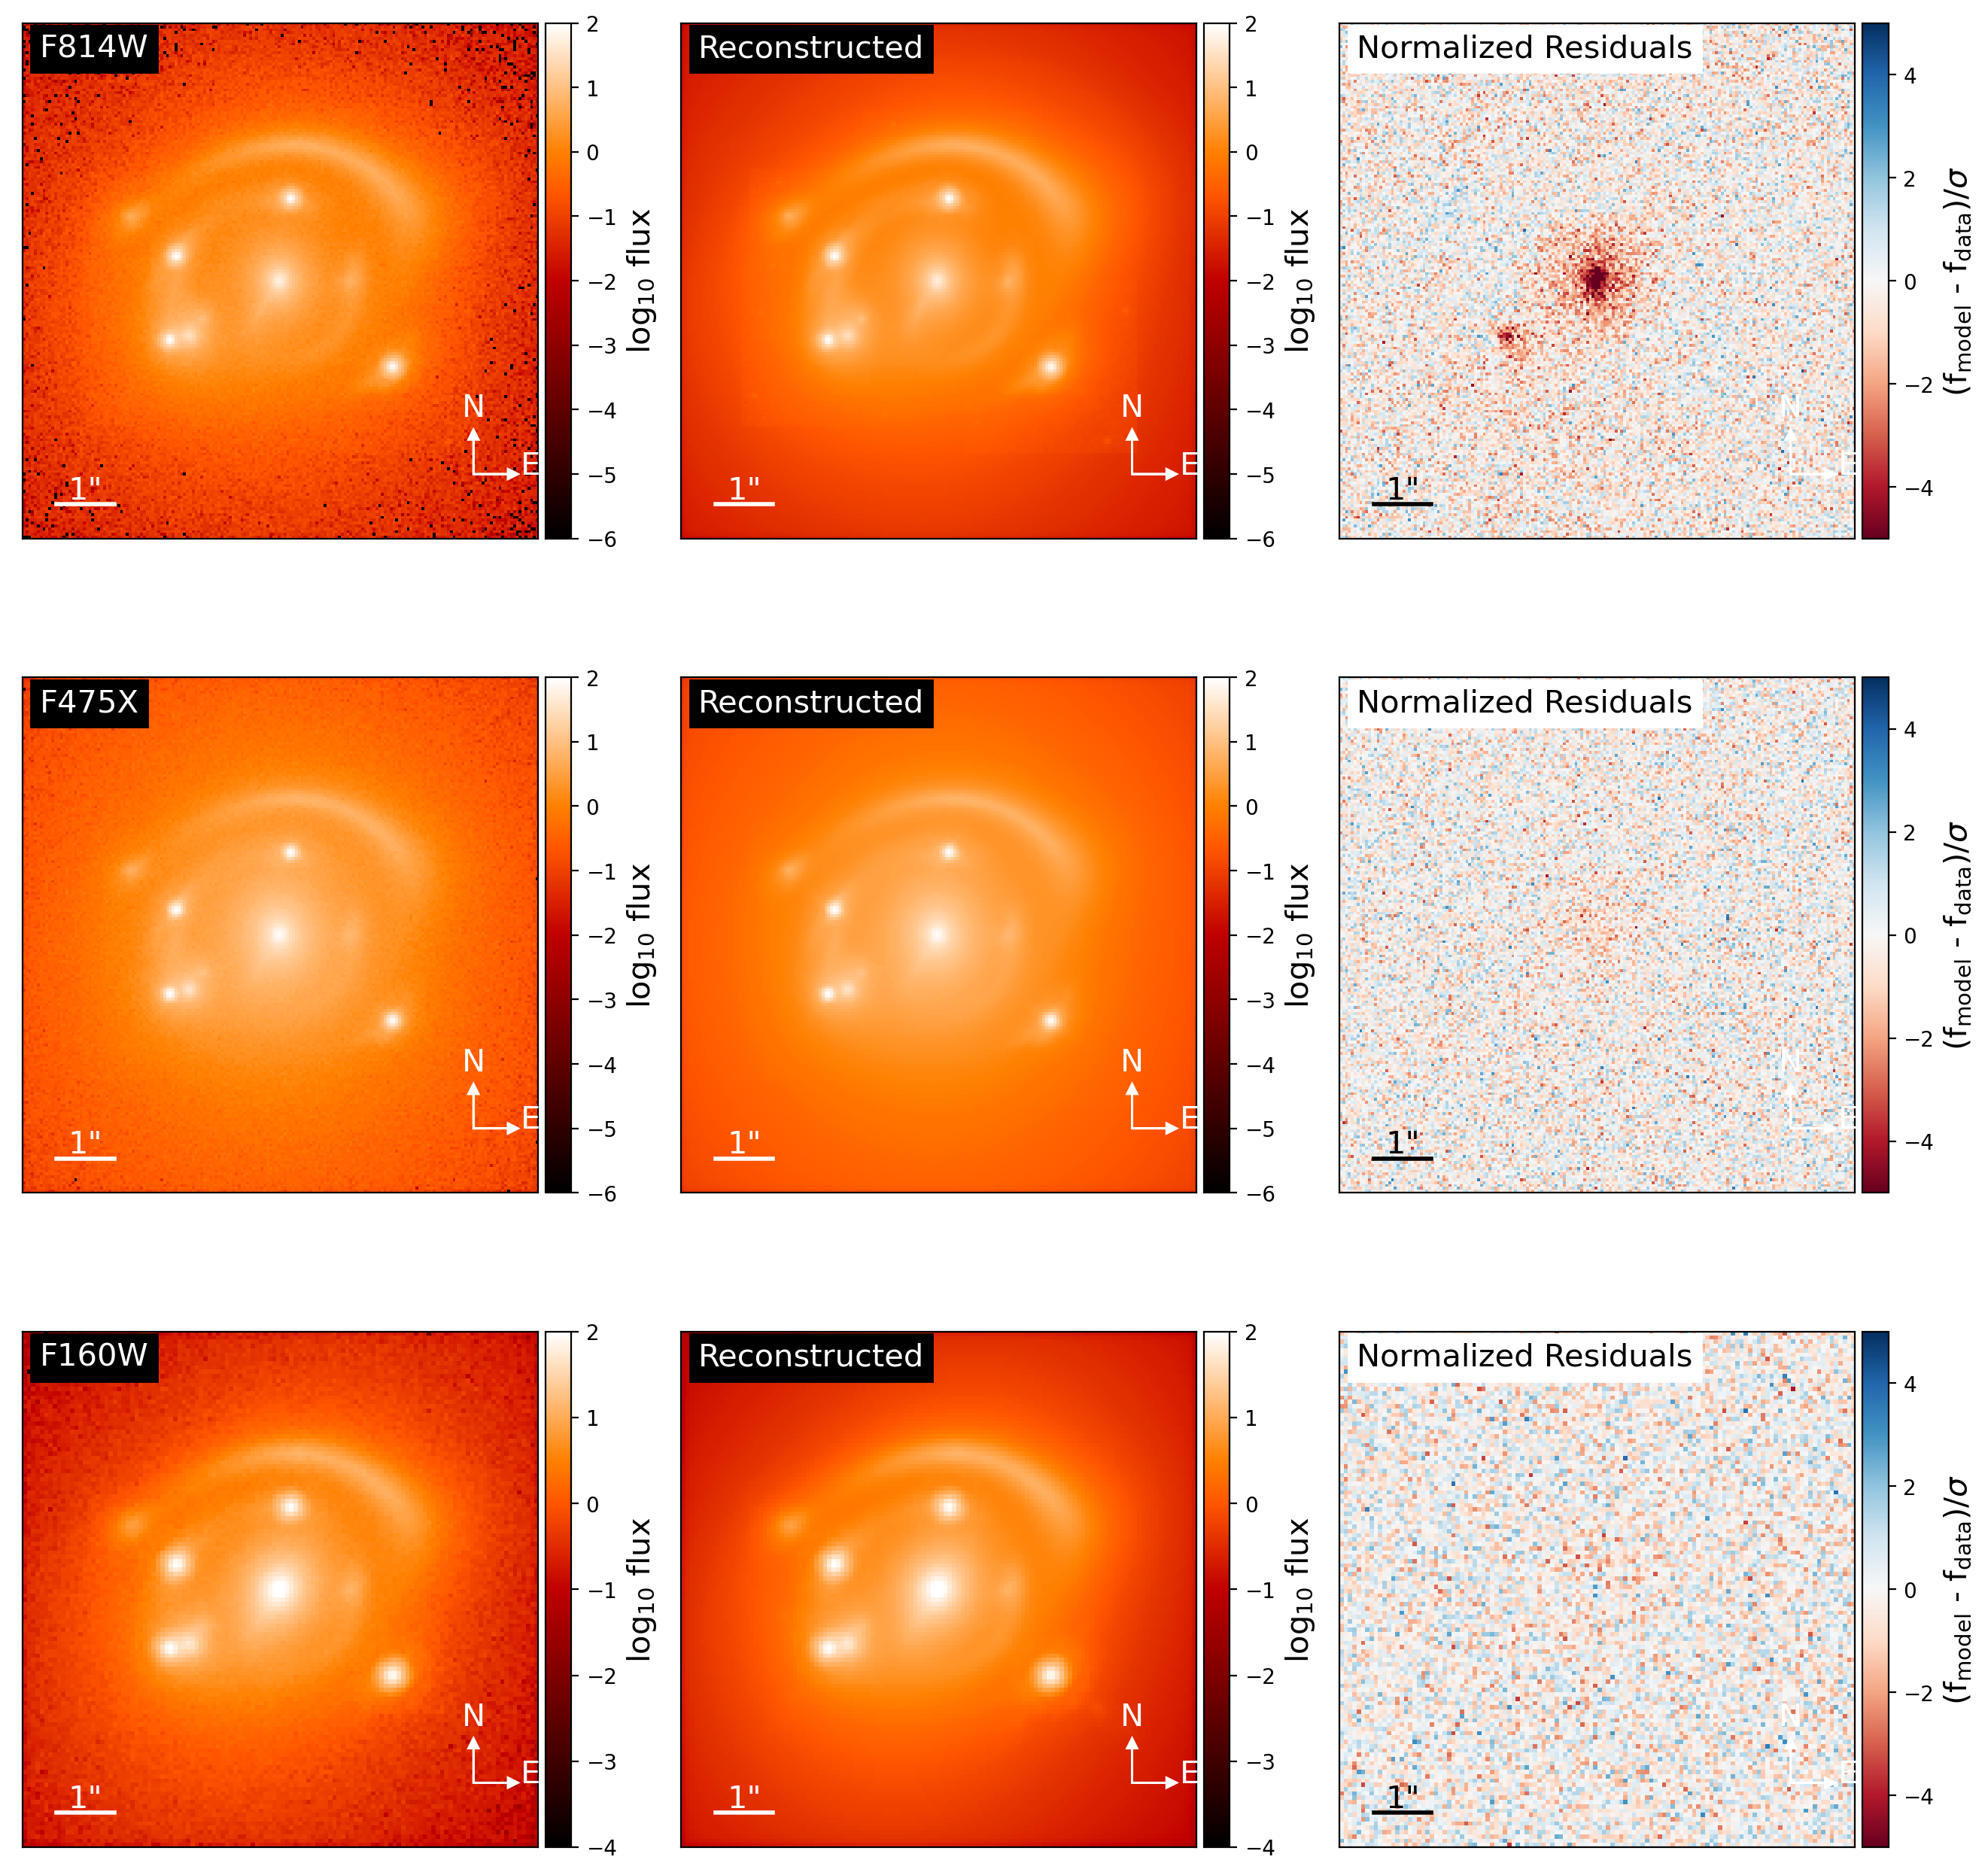

In [175]:
from astropy.cosmology import FlatLambdaCDM, wCDM
import astropy.units as u

cmap = 'cubehelix'
msh_cmap = 'RdBu'

if cosmow == True : 
    cosmo = wCDM(H0 = 5 * u.km / u.s / u.Mpc, Om0 = 0.01, Ode0 = 0.2, w0=-0.3, Tcmb0=0.0, Neff=3.04, m_nu=None, Ob0=None)
    data814 = np.loadtxt('image_sim814.txt')
    data475 = np.loadtxt('image_sim475.txt')
    data160 = np.loadtxt('image_sim160.txt')
else : 
    cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3, Ob0=0.05) # define cosmology 
    data814 = np.loadtxt('image_sim814bis.txt')
    data475 = np.loadtxt('image_sim475bis.txt')
    data160 = np.loadtxt('image_sim160bis.txt')


def import_data(filter_name):
    """
    """
        
    if filter_name == 'f160w' : 

        background_rms = .01 # background noise per pixel
        exp_time = 70  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
        numPix = 120  # cutout pixel size
        deltaPix = 0.075  # pixel size in arcsec (area per pixel = deltaPix**2)
        fwhm = 0.15  # full width half max of PSF
        
        kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
        data_class = ImageData(**kwargs_data)
        psf_file = os.path.join(base_path, 'data', 'psf_{}.hdf5'.format(filter_name))
        f = h5py.File(psf_file, 'r')
        kernel_point_source = f['kernel_point_source'][()]
        f.close()
        kwargs_psf = {'psf_type': 'PIXEL', 'fwhm': fwhm, 'kernel_point_source' : kernel_point_source,'pixel_size': deltaPix}
        psf_class = PSF(**kwargs_psf)
        kwargs_data['image_data'] = data160
        ra_at_xy_0 = kwargs_data['ra_at_xy_0']
        dec_at_xy_0 = kwargs_data['dec_at_xy_0']
        transform_pix2angle = kwargs_data['transform_pix2angle']
        coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

    if filter_name == 'f475x' : 

        background_rms = .005  # background noise per pixel
        exp_time = 70  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
        numPix = 180  # cutout pixel size
        deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
        fwhm = 0.15  # full width half max of PSF
        kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
        data_class = ImageData(**kwargs_data)
        psf_file = os.path.join(base_path, 'data', 'psf_{}.hdf5'.format(filter_name))
        f = h5py.File(psf_file, 'r')
        kernel_point_source = f['kernel_point_source'][()]
        f.close()
        kwargs_psf = {'psf_type': 'PIXEL', 'fwhm': fwhm, 'kernel_point_source' : kernel_point_source,'pixel_size': deltaPix}
        psf_class = PSF(**kwargs_psf)
        kwargs_data['image_data'] = data475
        ra_at_xy_0 = kwargs_data['ra_at_xy_0']
        dec_at_xy_0 = kwargs_data['dec_at_xy_0']
        transform_pix2angle = kwargs_data['transform_pix2angle']
        coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
            
    if filter_name == 'f814w' :

        background_rms = .005  # background noise per pixel
        exp_time = 70  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
        numPix = 180  # cutout pixel size
        deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
        fwhm = 0.15  # full width half max of PSF
        kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
        data_class = ImageData(**kwargs_data)
        psf_file = os.path.join(base_path, 'data', 'psf_{}.hdf5'.format(filter_name))
        f = h5py.File(psf_file, 'r')
        kernel_point_source = f['kernel_point_source'][()]
        f.close()
        kwargs_psf = {'psf_type': 'PIXEL', 'fwhm': fwhm, 'kernel_point_source' : kernel_point_source,'pixel_size': deltaPix}
        psf_class = PSF(**kwargs_psf)
        kwargs_data['image_data'] = data814
        ra_at_xy_0 = kwargs_data['ra_at_xy_0']
        dec_at_xy_0 = kwargs_data['dec_at_xy_0']
        transform_pix2angle = kwargs_data['transform_pix2angle']
        coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

    return kwargs_data, kwargs_psf, coords

kwargs_dataf160w, kwargs_psff160w, coordsf160w = import_data('f160w')
kwargs_dataf814w, kwargs_psff814w, coordsf814w = import_data('f814w')
kwargs_dataf475x, kwargs_psff475x, coordsf475x = import_data('f475x')

if cosmow == True : 
    with open('known_solution_simulation2.pickle', 'rb') as f:
        kwargs_result_old2 = pickle.load(f)
else : 
    with open('known_solution_simulation2bis.pickle', 'rb') as f:
        kwargs_result_old2 = pickle.load(f)

amp_source = 300
amp_lens = 300
amp_ps = 1000

tampon_lens2 = [{'theta_E': 1.630733482158986, 'gamma': 1.7356277714330814, 'e1': -0.008564148200000756, 'e2': 0.21337107343436382, 'center_x': 0.044568442028076576, 'center_y': 0.05368204192058385}, {'gamma_ext': 0.06886039874490402, 'psi_ext': 0.44433171264726073, 'ra_0': 0, 'dec_0': 0}, {'theta_E': 0.23406223967290868, 'center_x': -1.5953498841234257, 'center_y': -0.957809036129075}, {'theta_E': 0.34963329845029806, 'center_x': 1.0839901104658902, 'center_y': -6.516121582054507}, {'logM': 12.293473116012454, 'concentration': 5.2938866677526955, 'center_x': -0.39902264938181325, 'center_y': -13.577953376770608}, {'logM': 11.477597163775352, 'concentration': 5.70382830617051, 'center_x': 5.342383555962899, 'center_y': -0.7750999830473467}, {'logM': 11.976107801672256, 'concentration': 6.268418658636125, 'center_x': 10.900788854734145, 'center_y': 5.532826990356399}, {'theta_E': 0.015584169135015678, 'center_x': -0.23937757570238552, 'center_y': -0.42697007646715346}]

tampon_lens_light2 = [
{'amp': 300, 'R_sersic': 1.3107179349829883, 'n_sersic': 4.990590806229146, 'e1': -0.10074301681449246, 'e2': -0.007225875846854489, 'center_x': -0.0269328863916088, 'center_y': -0.0009476874990389448}, 
{'amp': 300, 'R_sersic': 2.6539953448774574, 'n_sersic': 4.382369291437385, 'e1': -0.10074301681449246, 'e2': -0.007225875846854489, 'center_x': -0.0269328863916088, 'center_y': -0.0009476874990389448}, 
{'amp': 300, 'R_sersic': 0.10000391466716309, 'n_sersic': 1.061939424085716, 'e1': -0.1654259380573182, 'e2': -0.0784929092899602, 'center_x': -0.0269328863916088, 'center_y': -0.0009476874990389448}, 
{'amp': 300, 'R_sersic': 1.96627037681673, 'n_sersic': 5.22087304581133, 'e1': -0.0747537167017987, 'e2': 0.09453396740332322, 'center_x': -0.0269328863916088, 'center_y': -0.0009476874990389448}, 
{'amp': 300, 'R_sersic': 0.7153455129669464, 'n_sersic': 5.47386849989048, 'center_x': -1.5953498841234257, 'center_y': -0.957809036129075}, 
{'amp': 300, 'R_sersic': 0.7153455129669464, 'n_sersic': 5.47386849989048, 'center_x': -1.5953498841234257, 'center_y': -0.957809036129075}, 
{'amp': 300, 'R_sersic': 0.7153455129669464, 'n_sersic': 5.47386849989048, 'center_x': -1.5953498841234257, 'center_y': -0.957809036129075}]

tampon_source2 = [
{'amp': 300, 'R_sersic': 0.1384339249900818, 'n_sersic': 4.578407529095215, 'e1': 0.1450869654923371, 'e2': -0.0948050061711261, 'center_x': 0.38271559291321455, 'center_y': -0.8854724336923326}, 
{'amp': np.array([-145.4652772,  -95.457246 , -342.0098006,  362.9274458,
         31.4860728,  807.0570954, -135.775063 , -385.1590964,
        438.5707994, -495.6887174,   88.2902438,  192.8002232,
          8.8235598, -242.6025906,  109.764719 , -116.9584056,
         69.9585814, -231.7726532,  450.530179 ,   22.379439 ,
        420.054362 ]), 'n_max': 5, 'beta': 0.06391939604087729, 'center_x': 0.38271559291321455, 'center_y': -0.8854724336923326}, 
{'amp': 300, 'R_sersic': 0.1384339249900818, 'n_sersic': 4.578407529095215, 'e1': 0.1450869654923371, 'e2': -0.0948050061711261, 'center_x': 0.38271559291321455, 'center_y': -0.8854724336923326}, 
{'amp': np.array([-145.4652772,  -95.457246 , -342.0098006,  362.9274458,
         31.4860728,  807.0570954, -135.775063 , -385.1590964,
        438.5707994, -495.6887174,   88.2902438,  192.8002232,
          8.8235598, -242.6025906,  109.764719 , -116.9584056,
         69.9585814, -231.7726532,  450.530179 ,   22.379439 ,
        420.054362 ]), 'n_max': 5, 'beta': 0.06391939604087729, 'center_x': 0.38271559291321455, 'center_y': -0.8854724336923326}, 
{'amp': 300, 'R_sersic': 0.1384339249900818, 'n_sersic': 4.578407529095215, 'e1': 0.1450869654923371, 'e2': -0.0948050061711261, 'center_x': 0.38271559291321455, 'center_y': -0.8854724336923326}, 
{'amp': 0.5*np.array([-168.84282318,  -10.78086995,  -11.6831123 ,   57.22708202,
         31.6744171 ,  123.69866753,    5.60308519,   14.94642406,
         -9.96951882,   43.49006012,  -55.03459537,  -18.19911784,
        -49.35243691,  -54.98649323,  -51.68494809,   -0.70939694,
         -2.25044995,  -30.71871349,    9.5072645 ,  -10.13080918,
        -25.31573946,   17.96336178,   14.28622533,    5.54252307,
         15.15183612,   41.26755763,   18.38773642,   23.25281581,
         -5.11325765,    5.74664848,   11.87829126,    2.74750154,
          1.84234304,    4.71111214,   -1.72486723,   -1.76581814,
        -16.96781979,   -3.05465211,    4.33773338,   -8.93583135,
         -3.04787762,  -14.78100285,   -9.35482107,    1.63408225,
        -23.91128135]), 'n_max': 8, 'beta': 0.11019702776464912, 'center_x': 0.38271559291321455, 'center_y': -0.8854724336923326}, 
{'amp': 300, 'R_sersic': 0.10926862916942076, 'n_sersic': 1.9511477861910127, 'e1': 0.21767526735440174, 'e2': -0.17377131188610687, 'center_x': -0.2486096521902502, 'center_y': -0.4300089078005465}, 
{'amp': np.array([ 464.8516802,  790.1919092, -352.6479768,  364.5957062,
       -278.2390454,  142.7464818,   34.2912008, -234.4921504,
         -6.3224778,  -94.9034732]), 'n_max': 3, 'beta': 0.06445713707040127, 'center_x': -0.2486096521902502, 'center_y': -0.4300089078005465}, 
{'amp': 300, 'R_sersic': 0.27501389572859, 'n_sersic': 1.6905976552642201, 'e1': 0.2304847171017094, 'e2': 0.30374241488788356, 'center_x': 0.4580329178635046, 'center_y': -0.19633835837213806}, 
{'amp': 300, 'R_sersic': 0.10926862916942076, 'n_sersic': 1.9511477861910127, 'e1': 0.21767526735440174, 'e2': -0.17377131188610687, 'center_x': -0.2486096521902502, 'center_y': -0.4300089078005465},
{'amp': np.array([ 464.8516802,  790.1919092, -352.6479768,  364.5957062,
       -278.2390454,  142.7464818,   34.2912008, -234.4921504,
         -6.3224778,  -94.9034732]), 'n_max': 3, 'beta': 0.06445713707040127, 'center_x': -0.2486096521902502, 'center_y': -0.4300089078005465}, 
{'amp': 300, 'R_sersic': 0.27501389572859, 'n_sersic': 1.6905976552642201, 'e1': 0.2304847171017094, 'e2': 0.30374241488788356, 'center_x': 0.4580329178635046, 'center_y': -0.19633835837213806}, 
{'amp': 300, 'R_sersic': 0.10926862916942076, 'n_sersic': 1.9511477861910127, 'e1': 0.21767526735440174, 'e2': -0.17377131188610687, 'center_x': -0.2486096521902502, 'center_y': -0.4300089078005465}, 
{'amp': np.array([ 464.8516802,  790.1919092, -352.6479768,  364.5957062,
       -278.2390454,  142.7464818,   34.2912008, -234.4921504,
         -6.3224778,  -94.9034732]), 'n_max': 3, 'beta': 0.06445713707040127, 'center_x': -0.2486096521902502, 'center_y': -0.4300089078005465}, 
{'amp': 300, 'R_sersic': 0.27501389572859, 'n_sersic': 1.6905976552642201, 'e1': 0.2304847171017094, 'e2': 0.30374241488788356, 'center_x': 0.4580329178635046, 'center_y': -0.19633835837213806}]

kwargs_extinction2 = [
{'amp': 0, 'R_sersic': 0.00703204837568565, 'n_sersic': 4.8684406080135885, 'center_x': -8.5953498841234257, 'center_y': -0.957809036129075},
{'amp': 0, 'R_sersic': 0.00703204837568565, 'n_sersic': 4.8684406080135885, 'center_x': -8.5953498841234257, 'center_y': -0.957809036129075},
{'amp': 0, 'R_sersic': 0.00703204837568565, 'n_sersic': 4.8684406080135885, 'center_x': -8.5953498841234257, 'center_y': -0.957809036129075}]

kwargs_test2 = kwargs_result_old2
kwargs_test2['kwargs_lens'] = tampon_lens2
kwargs_test2['kwargs_lens_light'] = tampon_lens_light2
kwargs_test2['kwargs_source'] = tampon_source2
if cosmow == True : 
    kwargs_test2['kwargs_ps'] = [{'ra_image': np.array([2.37612674, -2.41193701, -2.41294456, 0.13503457]), 'dec_image': np.array([-1.74483977, -0.03333289, -0.97537242, 1.66704018]), 'point_amp': np.array([amp_ps,amp_ps,amp_ps,amp_ps])}]
else : 
    kwargs_test2['kwargs_ps'] = [{'ra_image': np.array([1.95506024, -1.81992773, -1.93423272, 0.17445549]), 'dec_image': np.array([-1.49731766, 0.4310645, -1.03356661, 1.43369151]), 'point_amp': np.array([amp_ps,amp_ps,amp_ps,amp_ps])}]

kwargs_test2['kwargs_extinction'] = kwargs_extinction2
kwargs_numerics2 = {'supersampling_factor': 1, 'supersampling_convolution': False}

kwargs_model2 = {'lens_model_list': ['EPL', 'SHEAR_GAMMA_PSI', 'SIS', 'SIS', 'NFW_MC', 'NFW_MC', 'NFW_MC', 'SIS'], 
'source_light_model_list': ['SERSIC_ELLIPSE', 'SHAPELETS', 'SERSIC_ELLIPSE', 'SHAPELETS', 'SERSIC_ELLIPSE', 'SHAPELETS', 'SERSIC_ELLIPSE', 'SHAPELETS', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SHAPELETS', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SHAPELETS', 'SERSIC_ELLIPSE'], 
'lens_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC', 'SERSIC', 'SERSIC'], 
'point_source_model_list': ['LENSED_POSITION'], 
'index_lens_light_model_list': [[0, 4], [1, 5], [2, 3, 6]], 
'index_source_light_model_list': [[0, 1, 6, 7, 8], [2, 3, 9, 10, 11], [4, 5, 12, 13, 14]], 
'distance_ratio_sampling': False, 
'multi_plane': True, 
'lens_redshift_list': [0.597, 0.597, 0.597, 0.769, 0.597, 0.597, 0.597, 2.228], 
'cosmo': cosmo, 
'observed_convention_index': [3], 'z_source': 2.375, 'source_redshift_list': [2.375, 2.375, 2.375, 2.375, 2.375, 2.375, 2.228, 2.228, 2.375, 2.228, 2.228, 2.375, 2.228, 2.228, 2.375]}

if cosmow == True : 
    f = open('known_solution_simulation2.pickle','wb')
else : 
    f = open('known_solution_simulation2bis.pickle','wb')
pickle.dump(kwargs_test2, f)
f.close()   

if cosmow == True : 
    with open('known_solution_simulation2.pickle', 'rb') as f:
        kwargs_result_good2 = pickle.load(f)
else : 
    with open('known_solution_simulation2bis.pickle', 'rb') as f:
        kwargs_result_good2 = pickle.load(f)

lens_plot = ModelPlot([[kwargs_dataf814w, kwargs_psff814w, kwargs_numerics2],[kwargs_dataf475x, kwargs_psff475x, kwargs_numerics2],[kwargs_dataf160w, kwargs_psff160w, kwargs_numerics2]], kwargs_model2, kwargs_result_good2, arrow_size=0.02, cmap_string="gist_heat", multi_band_type='multi-linear', linear_solver=True)
f, axes = plt.subplots(3, 3, figsize=(16, 16), sharex=False, sharey=True)
lens_plot.data_plot(ax=axes[0, 0], band_index=0, v_max= 2, v_min=-6, text='F814W')
lens_plot.data_plot(ax=axes[1, 0], band_index=1, v_max= 2, v_min=-6, text='F475X')
lens_plot.data_plot(ax=axes[2, 0], band_index=2, v_max= 2, v_min=-4, text='F160W')

lens_plot.model_plot(ax=axes[0, 1], band_index=0, v_max= 2, v_min=-6)
lens_plot.model_plot(ax=axes[1, 1], band_index=1, v_max= 2, v_min=-6)
lens_plot.model_plot(ax=axes[2, 1], band_index=2, v_max= 2, v_min=-4)

lens_plot.normalized_residual_plot(ax=axes[0, 2], band_index=0, v_max=5, v_min=-5, cmap=msh_cmap)
lens_plot.normalized_residual_plot(ax=axes[1, 2], band_index=1, v_max=5, v_min=-5, cmap=msh_cmap)
lens_plot.normalized_residual_plot(ax=axes[2, 2], band_index=2, v_max=5, v_min=-5, cmap=msh_cmap)

plt.show()
#plt.close()